In [1]:
import tune_measure as tm
import numpy as np
import matplotlib.pyplot as plt
#%config Completer.use_jedi = False

# Analyzing the variation of precision with turns

In [2]:
N_max = 1000
KsL_list = -np.linspace(0,0.05,num=4)

coupling_list = np.zeros([KsL_list.size])
error_naff_tune1 = coupling_list.copy()
error_naff_tune2 = coupling_list.copy()
tune1_list = coupling_list.copy()
tune2_list = coupling_list.copy()
datax = np.zeros([coupling_list.size, N_max, 50])
datay = datax.copy()
offset = np.array(
    [[2e-6],
    [1e-6],
    [2e-6],
    [1e-6],
    [0],
    [0]]
    )

for KsL_idx, KsL in enumerate(KsL_list):        
        obj = tm.BPMeasure()
    
        obj.create_booster(KsL=KsL)
        coupling_list[KsL_idx] = obj._coupling_coef
        
        tune1, tune2 = obj._eqparams.tune1, obj._eqparams.tune2
        
        tune1_list[KsL_idx], tune2_list[KsL_idx] = tune1, tune2

        obj.create_initial_bunch(n_part=13000, offset=offset)
        x_m, y_m = obj.tracking_and_get_bpmdata(N_turns=N_max)
        datax[KsL_idx] = x_m
        datay[KsL_idx] = y_m
        print("step", KsL_idx, "done")

step 0 done
step 1 done
step 2 done
step 3 done


In [3]:
N_list = np.arange(20,N_max,20)
error1_matrix = np.zeros([coupling_list.size, N_list.size]) 
error2_matrix = error1_matrix.copy()

# Computes the error associated with a given N and coupling
for N_index, N in enumerate(N_list):
    for C_index, C in enumerate(coupling_list):
        # Gets the data referent to C_index system
        x_m, y_m = datax[C_index], datay[C_index]
        
        # Uses only the N first revolutions to calc tunes
        naff_tune1, naff_tune2 = tm.tune_by_NAFF(x_m[:N,:], y_m[:N,:])
        naff_tune1, naff_tune2 = naff_tune1%1, naff_tune2%1  # Stores only decimal part
        
        # Passes the errors to the matrices
        error1_matrix[C_index][N_index] = np.abs(naff_tune1 - tune1_list[C_index])
        error2_matrix[C_index][N_index] = np.abs(naff_tune2 - tune2_list[C_index])

In [17]:
np.save("datax", datax)
np.save("datay", datay)

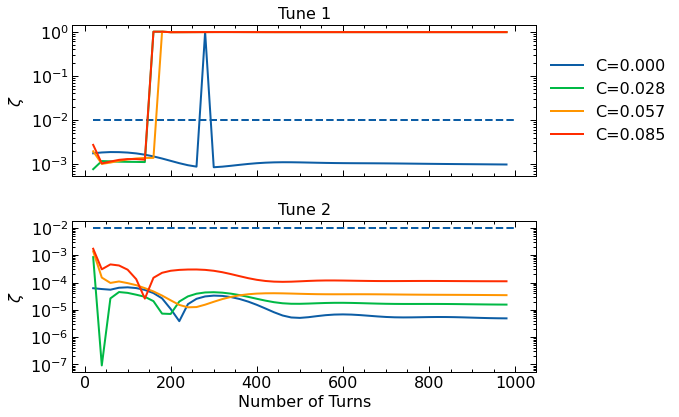

In [14]:
rel_error1_matrix = error1_matrix/tune1_list.reshape([4,1])
rel_error2_matrix = error2_matrix/tune2_list.reshape([4,1])

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots(2,1, sharex=True)
    fig.tight_layout(pad=3.0)
    #fig.set_dpi(160)
    for c_idx, c in enumerate(coupling_list):
        ax[0].semilogy(N_list, rel_error1_matrix[c_idx, :], label="C={:.3f}".format(c))
        ax[1].semilogy(N_list, rel_error2_matrix[c_idx, :], label="C={:.3f}".format(c))        

    ax[0].set_title("Tune 1")
    ax[0].set_ylabel("$\zeta$") #Zeta is the relative error
    ax[0].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[1].set_title("Tune 2")
    ax[1].set_ylabel("$\zeta$")
    ax[1].set_xlabel("Number of Turns")
    ax[1].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #ax[1].text(x=210, y=0.00001, s="\n initial amplitudes: \n $x_0 = {} \, \mu m$"
                                    # "\n $x'_0 = {} \, \mu rad$"
                                    # "\n $y_0 = {} \, \mu m$"
                                    # "\n $y'_0 = {} \, \mu rad$".format(offset[0][0]*1e6, offset[1][0]*1e6, offset[2][0]*1e6, offset[3][0]*1e6), fontsize = 15)

# Squematic graphs 

Text(0, 0.5, '$\\epsilon$ [nm]')

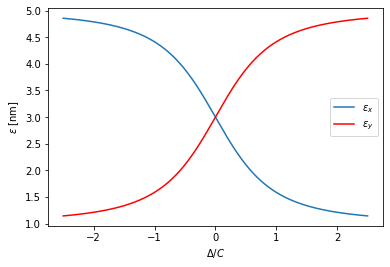

In [15]:
C = 0.02
delta1 = np.linspace(-0.05,0,num=600)
delta2 = np.linspace(0,0.05,num=600)

delta = np.concatenate([delta1,delta2])
emitx0 = 5
emity0 = 1

emitx1 = emitx0 + C**2/(delta1**2 + C**2 + np.abs(delta1)*np.sqrt(delta1**2 + C**2)) * (emity0 - emitx0)/2
emitx2 = emitx0 + C**2/(delta2**2 + C**2 - np.abs(delta2)*np.sqrt(delta2**2 + C**2)) * (emity0 - emitx0)/2

emitx = np.concatenate([emitx1, emitx2])

emity1 = emity0 - C**2/(delta1**2 + C**2 + np.abs(delta1)*np.sqrt(delta1**2 + C**2)) * (emity0 - emitx0)/2
emity2 = emity0 - C**2/(delta2**2 + C**2 - np.abs(delta2)*np.sqrt(delta2**2 + C**2)) * (emity0 - emitx0)/2

emity = np.concatenate([emity1, emity2])

plt.plot(delta/C, emitx, label="$\epsilon_x$")
plt.plot(delta/C, emity, label="$\epsilon_y$", c='r')
plt.legend(loc="best")
plt.xlabel('$\Delta/C$')
plt.ylabel("$\epsilon$ [nm]")

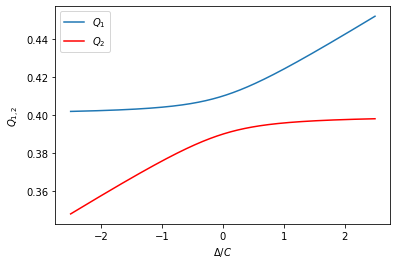

In [16]:
q2 = 0.4
q1 = q2 + delta


q1 = q1 - delta/2 + np.sqrt(delta**2 + C**2)/2
q2 = q2 + delta/2 - np.sqrt(delta**2 + C**2)/2
plt.plot(delta/C, q1, label ="$Q_1$")
plt.plot(delta/C, q2, label = "$Q_2$", c='r')
plt.xlabel('$\Delta/C$')
plt.ylabel("$Q_{1,2}$")
plt.legend()